In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

In [5]:
from dope.pools.pools import Pool
from dope.backengine.maestro import BackEngineMaestro

In [65]:
maestro = BackEngineMaestro()

pools = [

#   Pool(
#     chain="Ethereum",
#     symbol="WBTC-USDT",
#     protocol="aave-v3",
#     ltv=0.8,
#     deposit_token="WBTC",
#     deposit_token_keyid="wrapped-bitcoin",
#     deposit_pool_id="7e382157-b1bc-406d-b17b-facba43b716e",
#     debt_token="USDT",
#     debt_token_keyid="tether",
#     debt_pool_id="f981a304-bb6c-45b8-b0c5-fd2f515ad23a",
#   ),
#   Pool(
#     chain="Ethereum",
#     symbol="USDT",
#     protocol="compound-v2",
#     ltv=0.8,
#     debt_token=None,
#     debt_pool_id=None,
#     deposit_token="USDT",
#     deposit_token_keyid="tether",
#     deposit_pool_id="57647093-2868-4e65-97ab-9cae8ec74e7d",
#     debt_token_keyid=None,
#   ),

  Pool(
    chain="Ethereum",
    symbol="STETH-ETH",
    protocol="aave-v3",
    ltv=0.93,
    LT=0.95,
    debt_token="ETH",
    debt_token_keyid="ethereum",
    debt_pool_id="e880e828-ca59-4ec6-8d4f-27182a4dc23d",
    deposit_token="STETH",
    deposit_token_keyid="staked-ether",
    deposit_pool_id="e6435aae-cbe9-4d26-ab2c-a4d533db9972",
  ),

  Pool(
    chain="Ethereum",
    symbol="STETH",
    protocol="lido",
    ltv=1,
    LT=np.inf,
    debt_token="STETH",
    debt_token_keyid="staked-ether",
    debt_pool_id=None,
    deposit_token="ETH",
    deposit_token_keyid="ethereum",
    deposit_pool_id="747c1d2a-c668-4682-b9f9-296708a3dd90", # ETH staked accrues on stETH rates
  ),
  
]

In [66]:
# Download data
_ = maestro.load_pools_data(pools)

Ethereum:aave-v3:WETH e880e828-ca59-4ec6-8d4f-27182a4dc23d 491 491
Ethereum:aave-v3:WSTETH e6435aae-cbe9-4d26-ab2c-a4d533db9972 491 491
Ethereum:lido:STETH 747c1d2a-c668-4682-b9f9-296708a3dd90 464 464


In [67]:
# The data is download only once
_ = maestro.load_pools_data(pools)

In [68]:
# Download price data
maestro.load_price_data(pools)

Data for staked-ether with 366 rows
Data for ethereum with 366 rows


In [69]:
# The data is download only once 
maestro.load_price_data(pools)

# Plotting Data

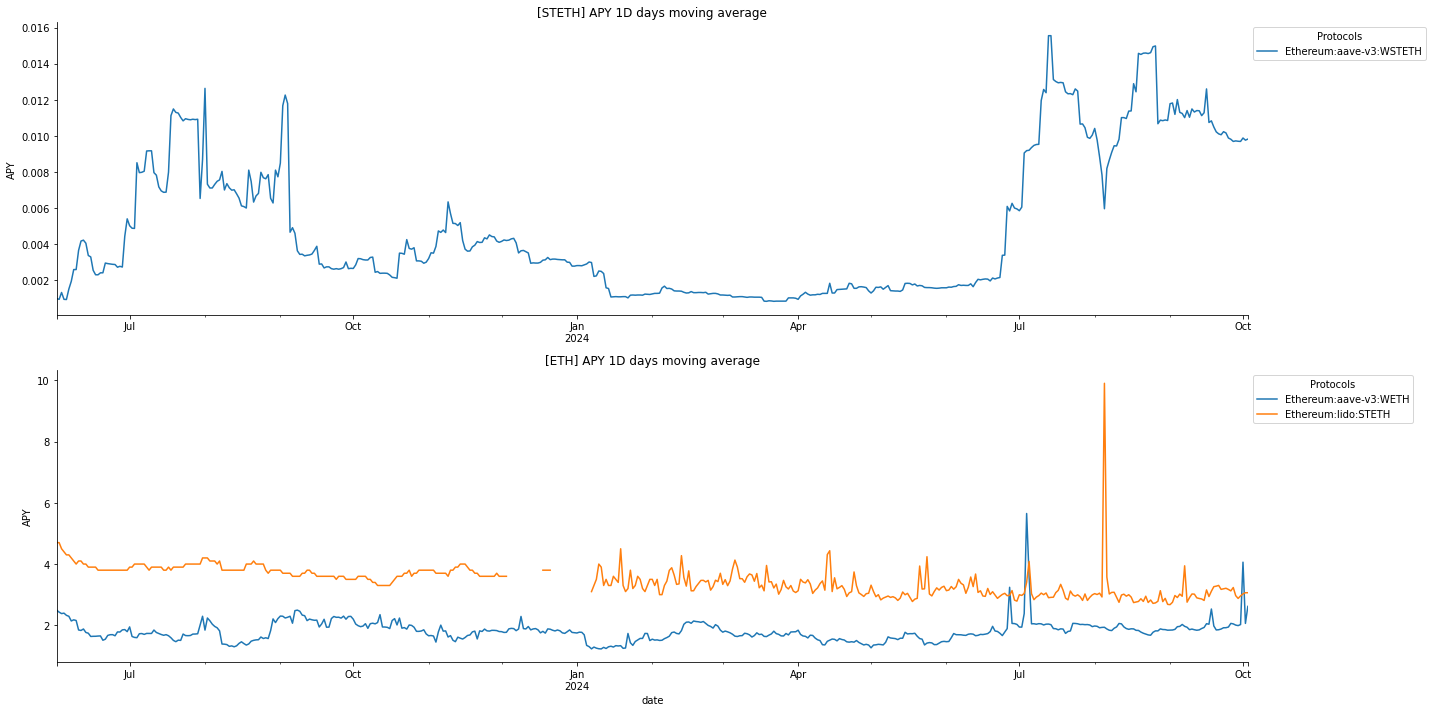

In [70]:
maestro.plot_rates_ts(maestro.rates_data_collection, rate_column='apyBase')

In [71]:
# from dope.backengine.estimators.estimator import Estimator
# from dope.backengine.estimators.clippedestimator import ClippedEstimator
# from dope.backengine.triggers.confidencebandtrigger import ConfidenceBandTrigger

# from dope.backengine.maestro import BackEngineMaestro
# _data = pd.concat(borrow_lend_data['stETH'], names=["datetime"]).unstack(level=0)
# lag = 7 # 1 week window for mu and sigma estimation
# triggerObj = ConfidenceBandTrigger(_data, lag, Estimator(), rt_col='apyBaseBorrow')
# triggers2 = triggerObj.dates()

# BackTester

In [72]:
from dope.backengine.agents.looper import Looper
from dope.backengine.loopengine import LoopBacktester
from dope.token import Token

In [77]:
# run_data = borrow_lend_data.convert_tvl_from_usd(eth)

In [78]:
pair_pool, deposit_pool = pools[-2], pools[-1]
pair_pool, deposit_pool

(Ethereum:aave-v3:(debt:ETH(e880e828-c), deposit:STETH(e6435aae-c)),
 Ethereum:lido:(debt:STETH(None), deposit:ETH(747c1d2a-c)))

In [83]:
summary = {}

capital = Token(10, pair_pool.deposit_token)
loop = 10

for loop in [1, 5, 10, 20, 30]:
  strategy = Looper(
    capital=capital,
    pair_pool=pair_pool,
    deposit_pool=deposit_pool,
    loop_n=loop,
    buffer=0.1
  )
  strategy.verbose=False

  maestro.convert_data_to_base_token("ETH")

  # uncomment next line to output values in dollar terms
  # maestro.convert_data_to_base_token("dollar")

  bt = LoopBacktester(
    strategy=strategy,
    data=maestro.rates_data_in_base_token,
    price_data=maestro.price_data_collection, 
    pools=maestro.pools,
  )
  summary[f"loop:{loop}x"] = bt()

Running Backtest for 491
Running Backtest for 491
Running Backtest for 491
Running Backtest for 491
Running Backtest for 491


# Analysis

In [84]:
from dope.backengine.plotting.simple import Plotter

plotter = Plotter(summary)

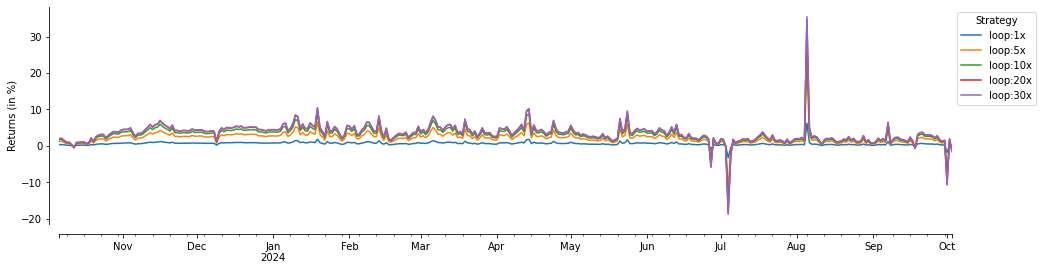

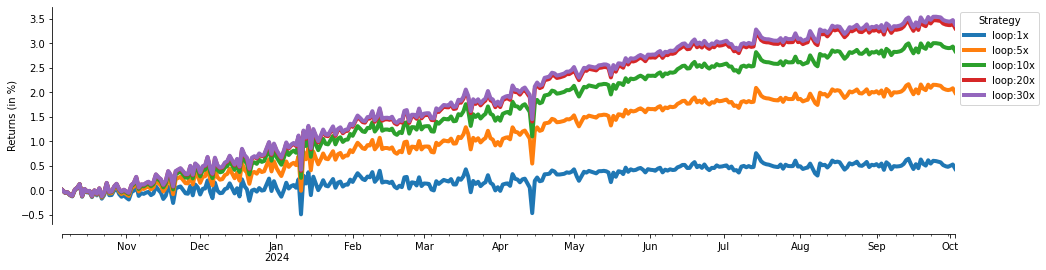

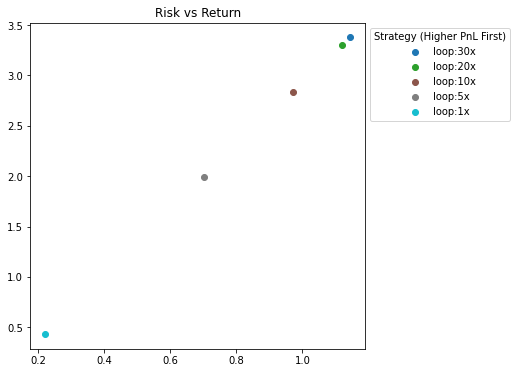

loop:1x     0.433848
loop:5x     1.986656
loop:10x    2.836719
loop:20x    3.303449
loop:30x    3.375867
dtype: float64


In [85]:
plotter.summary_view()